In [155]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from fastDamerauLevenshtein import damerauLevenshtein
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, GridSearchCV
from tensorflow.keras import layers

In [4]:
df = pd.read_csv('data/single_step_df_ints_2022-03-15.csv')

In [7]:
float_cols = df.select_dtypes(include=['float64']).columns
df.loc[:, float_cols] = df.loc[:, float_cols].fillna(-99)

In [8]:
df['target'].unique()
df['target'].value_counts()

df['target'].loc[df['target'] == 'l']

727    l
Name: target, dtype: object

In [9]:
nr_of_sequences = len(df[df['input'] == '<start>'])

In [55]:
# remove row with target that only occurs once

df_new = df.drop(index=727, axis=0)
df_new.reset_index(inplace=True, drop=True)

In [11]:
# generate stratified split for train - test/val

split = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=42)

for train_index, test_index in split.split(df_new, df_new['target']):
    strat_train = df_new.loc[train_index]
    strat_test_val = df_new.loc[test_index]

In [12]:
# split test_val into test and val

split_test_val = len(strat_test_val)//2

strat_test = strat_test_val[:split_test_val]
strat_val = strat_test_val[split_test_val:]

In [13]:
# generate list of labels to pass to MultiLabelBinarizer so there's the same number of
# classes for all datasets

labels = df_new['target'].unique()

In [14]:
def create_dataset(dataframe, labels, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels_ds = df.pop('target')
    encoder = MultiLabelBinarizer(classes=labels)
    encoded_labels = encoder.fit_transform(labels_ds)
    
    df = {key: value[:, tf.newaxis] for key, value in df.items()}
    dataset = tf.data.Dataset.from_tensor_slices((dict(df), encoded_labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe))
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(batch_size)
    
    return dataset

In [15]:
batch_size = 256

In [16]:
train_ds = create_dataset(strat_train, labels, batch_size=batch_size)
val_ds = create_dataset(strat_val, labels, shuffle=False, batch_size=batch_size)
test_ds = create_dataset(strat_test, labels, shuffle=False, batch_size=batch_size)

/tmp/ipykernel_14217/1510453973.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key, value in df.items()}
2022-03-16 08:25:20.674144: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 08:25:20.674611: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-16 08:25:20.674873: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-16 08:25:20.675148: W tensorflow

In [17]:
#[(train_features, label_batch)] = train_ds.take(1)
#print('Every feature:', list(train_features.keys()))
#print('A batch of targets:', label_batch)

In [18]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
    normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
    normalizer.adapt(feature_ds)
    
    return normalizer

In [19]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)
        
    # prepare tf.data.Dataset that only yields the feature    
    feature_ds = dataset.map(lambda x, y: x[name])
    
    # learn set of possible values and assign fixed int index
    index.adapt(feature_ds)
    
    # encode int indices
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())
    
    # apply multi-hot encoding to indices
    # lambda function captures the layer to include them in Keras functional models later
    return lambda feature: encoder(index(feature))

In [20]:
def create_input_data(dataframe):
    all_inputs = []
    encoded_features = []
    
    for header in dataframe.columns:
        # numerical features
        if 'coord' in header or 'already' in header:
            numeric_col = tf.keras.Input(shape=(1,), name=header)
            normalization_layer = get_normalization_layer(header, train_ds)
            encoded_numeric_col = normalization_layer(numeric_col)
            all_inputs.append(numeric_col)
            encoded_features.append(encoded_numeric_col)
        
        # categorical features
        elif 'containment' in header or 'food' in header or 'mid' in header or \
        'strong' in header:
            categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
            encoding_layer = get_category_encoding_layer(name=header,
                                                        dataset=train_ds,
                                                        dtype='int64')
            encoded_categorical_col = encoding_layer(categorical_col)
            all_inputs.append(categorical_col)
            encoded_features.append(encoded_categorical_col)
            
        elif header == 'input':
            categorical_col = tf.keras.Input(shape=(1,), name='input', dtype='string')
            encoding_layer = get_category_encoding_layer(name='input',
                                                        dataset=train_ds,
                                                        dtype='string')
            encoded_categorical_col = encoding_layer(categorical_col)
            all_inputs.append(categorical_col)
            encoded_features.append(encoded_categorical_col)
            
    return all_inputs, encoded_features

In [21]:
all_inputs, encoded_features = create_input_data(df)

In [41]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [83]:
# use model from tutorial with dense layers

all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(512, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(20)(x)

model = tf.keras.Model(all_inputs, output)

In [84]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])

In [85]:
#tf.keras.utils.plot_model(model, show_shapes=True, rankdir='LR')

In [87]:
history = model.fit(train_ds, epochs=200, validation_data=val_ds, callbacks=[callback])

Epoch 1/200
4/4 [==============================] - 3s 877ms/step - loss: 2.9365 - accuracy: 0.1145 - val_loss: 2.4611 - val_accuracy: 0.2000
Epoch 2/200
4/4 [==============================] - 0s 43ms/step - loss: 2.5066 - accuracy: 0.1947 - val_loss: 2.2494 - val_accuracy: 0.2909
Epoch 3/200
4/4 [==============================] - 0s 44ms/step - loss: 2.3401 - accuracy: 0.1869 - val_loss: 2.1262 - val_accuracy: 0.3409
Epoch 4/200
4/4 [==============================] - 0s 45ms/step - loss: 2.1991 - accuracy: 0.2221 - val_loss: 2.0503 - val_accuracy: 0.3591
Epoch 5/200
4/4 [==============================] - 0s 44ms/step - loss: 2.1229 - accuracy: 0.2231 - val_loss: 1.9947 - val_accuracy: 0.3955
Epoch 6/200
4/4 [==============================] - 0s 43ms/step - loss: 2.0506 - accuracy: 0.2485 - val_loss: 1.9457 - val_accuracy: 0.4318
Epoch 7/200
4/4 [==============================] - 0s 46ms/step - loss: 2.0268 - accuracy: 0.2622 - val_loss: 1.8968 - val_accuracy: 0.4227
Epoch 8/200
4/4 [==

4/4 [==============================] - 0s 43ms/step - loss: 1.0499 - accuracy: 0.6341 - val_loss: 1.2729 - val_accuracy: 0.5727
Epoch 60/200
4/4 [==============================] - 0s 46ms/step - loss: 1.0330 - accuracy: 0.6497 - val_loss: 1.2748 - val_accuracy: 0.5682
Epoch 61/200
4/4 [==============================] - 0s 44ms/step - loss: 1.0131 - accuracy: 0.6644 - val_loss: 1.2692 - val_accuracy: 0.5727
Epoch 62/200
4/4 [==============================] - 0s 42ms/step - loss: 1.0028 - accuracy: 0.6419 - val_loss: 1.2642 - val_accuracy: 0.5773
Epoch 63/200
4/4 [==============================] - 0s 43ms/step - loss: 1.0116 - accuracy: 0.6429 - val_loss: 1.2619 - val_accuracy: 0.5864
Epoch 64/200
4/4 [==============================] - 0s 45ms/step - loss: 1.0077 - accuracy: 0.6448 - val_loss: 1.2652 - val_accuracy: 0.5773
Epoch 65/200
4/4 [==============================] - 0s 44ms/step - loss: 1.0178 - accuracy: 0.6389 - val_loss: 1.2677 - val_accuracy: 0.5864
Epoch 66/200
4/4 [========

In [92]:
history.history['accuracy'][-1]

0.6780821681022644

In [54]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

1/1 [==============================] - 0s 95ms/step - loss: 1.4104 - accuracy: 0.5251
Accuracy 0.5251141786575317


In [109]:
def get_model_accuracy(train_ds, test_ds, val_ds, 
                       all_inputs=all_inputs, encoded_features=encoded_features,
                       callback=callback):
    accuracy_list = []
    
    dropout_rate = [0.2,0.3,0.4,0.5,0.6,0.7]
    neurons = [128,256,512,1024]
    
    for dropout in dropout_rate:
        for neuron_nr in neurons:
            all_features = tf.keras.layers.concatenate(encoded_features)
            x = tf.keras.layers.Dense(neuron_nr, activation='relu')(all_features)
            x = tf.keras.layers.Dropout(dropout)(x)
            x = tf.keras.layers.Dense(neuron_nr//2, activation='relu')(all_features)
            x = tf.keras.layers.Dropout(dropout)(x)
            output = tf.keras.layers.Dense(20)(x)
    
            model = tf.keras.Model(all_inputs, output)
    
            model.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])
    
            history = model.fit(train_ds, epochs=200, validation_data=val_ds, 
                                callbacks=[callback], verbose=0)
            accuracy = history.history['accuracy'][-1]
    
            loss, accuracy_test = model.evaluate(test_ds)
    
            accuracy_list.append([accuracy, accuracy_test, 'params (neurons, dropout): ', neuron_nr, dropout])
    
    return accuracy_list

In [94]:
model_test = create_model(128, 0.5, all_inputs, encoded_features)

In [ ]:
model_test.fit(train_ds, epochs=200, validation_data=val_ds, callbacks=[callback])

In [110]:
accuracies = get_model_accuracy(train_ds, test_ds, val_ds, all_inputs, encoded_features, callback)

1/1 [==============================] - 0s 104ms/step - loss: 1.4966 - accuracy: 0.5251


In [150]:
results = pd.DataFrame(columns=['accuracy', 'test_accuracy', 'neurons', 'dropout'])
results['accuracy'] = [lst[0] for lst in accuracies]
results['test_accuracy'] = [lst[1] for lst in accuracies]
results['neurons'] = [lst[3] for lst in accuracies]
results['dropout'] = [lst[4] for lst in accuracies]
results['diff'] = abs(results['accuracy'] - results['test_accuracy'])

In [152]:
highest_acc = results['accuracy'].idxmax()
lowest_diff = results['diff'].idxmin()

results.loc[highest_acc, :]
results.loc[lowest_diff, :]

accuracy           0.533268
test_accuracy      0.520548
neurons          128.000000
dropout            0.500000
diff               0.012720
Name: 12, dtype: float64

In [153]:
results

,accuracy,test_accuracy,neurons,dropout,diff
0,0.650685,0.520548,128,0.2,0.130137
1,0.686888,0.520548,256,0.2,0.166341
2,0.740704,0.538813,512,0.2,0.201892
3,0.746575,0.515982,1024,0.2,0.230594
4,0.636986,0.552511,128,0.3,0.084475
5,0.621331,0.511416,256,0.3,0.109915
6,0.739726,0.515982,512,0.3,0.223744
7,0.755382,0.515982,1024,0.3,0.239400
8,0.562622,0.529680,128,0.4,0.032942
9,0.619374,0.515982,256,0.4,0.103392


<AxesSubplot:>

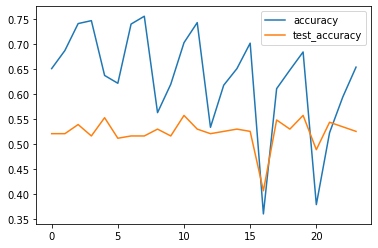

In [169]:
ax = plt.gca()

results.plot(kind='line', y='accuracy', ax=ax)
results.plot(kind='line', y='test_accuracy', ax=ax)

In [38]:
#model.save('models/next_obj_classifier_2022-03-15')

2022-03-15 14:05:03.524192: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/next_obj_classifier_2022-03-15/assets


INFO:tensorflow:Assets written to: models/next_obj_classifier_2022-03-15/assets


In [86]:
#reloaded_model = tf.keras.models.load_model('next_obj_classifier')

In [2]:
# test prediction for one sample

'''
sample = df.loc[0].drop('target').to_dict()
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
prediction = reloaded_model.predict(input_dict)
prediction = tf.nn.sigmoid(prediction[0])

# get label for prediction

pred_label = labels[np.argmax(prediction)]
pred_label

'''

"\nsample = df.loc[0].drop('target').to_dict()\ninput_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}\nprediction = reloaded_model.predict(input_dict)\nprediction = tf.nn.sigmoid(prediction[0])\n\n# get label for prediction\n\npred_label = labels[np.argmax(prediction)]\npred_label\n\n"

In [32]:
def get_prequential_error(dataframe, model, labels, nr_of_sequences):
    errors = [[] for seq in range(0, nr_of_sequences + 1)]
    start_token_count = 0
    sequence_nr = 0
    
    for row in range(0, len(dataframe)): 
        observed_target = dataframe.loc[row, 'target']
        sample = dataframe.loc[row].drop('target').to_dict()
        input_dict = {name: tf.convert_to_tensor([value]) for name, value in 
                          sample.items()}
        predicted_target = model.predict(input_dict)
        predicted_target = tf.nn.sigmoid(predicted_target[0])
            
        pred_label = labels[np.argmax(predicted_target)]
        error = 1 - damerauLevenshtein(pred_label, observed_target)
        errors[sequence_nr].append(error)
        
        if row != 0 and dataframe.loc[row, 'input'] == '<start>':
            start_token_count += 1
        
        if start_token_count > 0:
            sequence_nr += 1
            start_token_count = 0
            
    return errors

In [33]:
errors = get_prequential_error(df, model, labels, nr_of_sequences)

In [34]:
summed_error = [sum(error) for error in errors[:-1]]

In [35]:
np.median(summed_error)

2.0

In [37]:
#with open('results/nn_spatialinfo_prequential_summed_2022-03-15.txt', 'w') as file:
#    file.write(str(summed_error))